## Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import seaborn as sns

from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import json

## Charger les données de Bordeaux

In [2]:
# Chargement depuis parquet
df = pd.read_parquet("../data/clean/bordeaux_2022.parquet")

# Filtrer biens avec exactement 4 pièces principales
df_4p = df[df['Nombre pieces principales'] == 4].copy()

## préparation des données immobilières

In [3]:
colonnes_a_garder = [
    'Surface reelle bati',
    'Nombre pieces principales',
    'Nombre de lots',
    'Valeur fonciere',
    'Surface terrain',
    'Code type local',
    'prix_m2'
]

# logements
df_logements = df_4p[colonnes_a_garder].copy()

## Nettoyage et filtrage des données immobilières

In [4]:
# Remplacer Surface terrain NaN par 0 pour les appartements (Code type local == 2)
df_logements.loc[
    (df_logements["Code type local"] == 2) & (df_logements["Surface terrain"].isna()),
    "Surface terrain"
] = 0

# Remplacer Surface terrain NaN par 0 pour les maisons (Code type local == 1)
df_logements.loc[
    (df_logements["Code type local"] == 1) & (df_logements["Surface terrain"].isna()),
    "Surface terrain"
] = 0


#mettre surface terrain à 0 pour les appartements
#df_logements.loc[df_logements["Code type local"] == 2, "Surface terrain"] = 0

#mettre le nombre de lots pour les maison à 0
#df_logements.loc[df_logements["Code type local"] == 1, "Nombre de lots"] = 0

df_logements = df_logements.dropna()

print(len(df_logements))

1071


In [5]:
#séparation du dataset
df_bx_maisons_raw = df_logements[df_logements["Code type local"] == 1]
df_bx_apt_raw = df_logements[df_logements["Code type local"] == 2]

#df_maison = df_logements
#df_appartement = df_logements

In [6]:
def detect_outliers(df, column):
    
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR

    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

    return lower_bound, upper_bound, outliers

In [7]:
def remove_outliers(df, column):
    lower, upper, _ = detect_outliers(df, column)
    return df[(df[column] >= lower) & (df[column] <= upper)]

def median_outliers(df, column):
    lower, upper, _ = detect_outliers(df, column)
    mediane = df[column].median()
    df.loc[(df[column] < lower) | (df[column] > upper), column] = mediane
    return df

In [8]:
df_bx_maisons_clean = median_outliers(df_bx_maisons_raw, "prix_m2")
df_bx_apt_clean = median_outliers(df_bx_apt_raw, "prix_m2")

df_bx_maisons_clean = median_outliers(df_bx_maisons_raw, "Nombre de lots")
df_bx_apt_clean = median_outliers(df_bx_apt_raw, "Nombre de lots")

df_bx_maisons_clean = median_outliers(df_bx_maisons_raw, "Surface terrain")
df_bx_apt_clean = median_outliers(df_bx_apt_raw, "Surface terrain")

df_bx_maisons_clean = median_outliers(df_bx_maisons_raw, "Surface reelle bati")
df_bx_apt_clean = median_outliers(df_bx_apt_raw, "Surface reelle bati")

print(len(df_bx_maisons_clean))
print(len(df_bx_apt_clean))

408
663


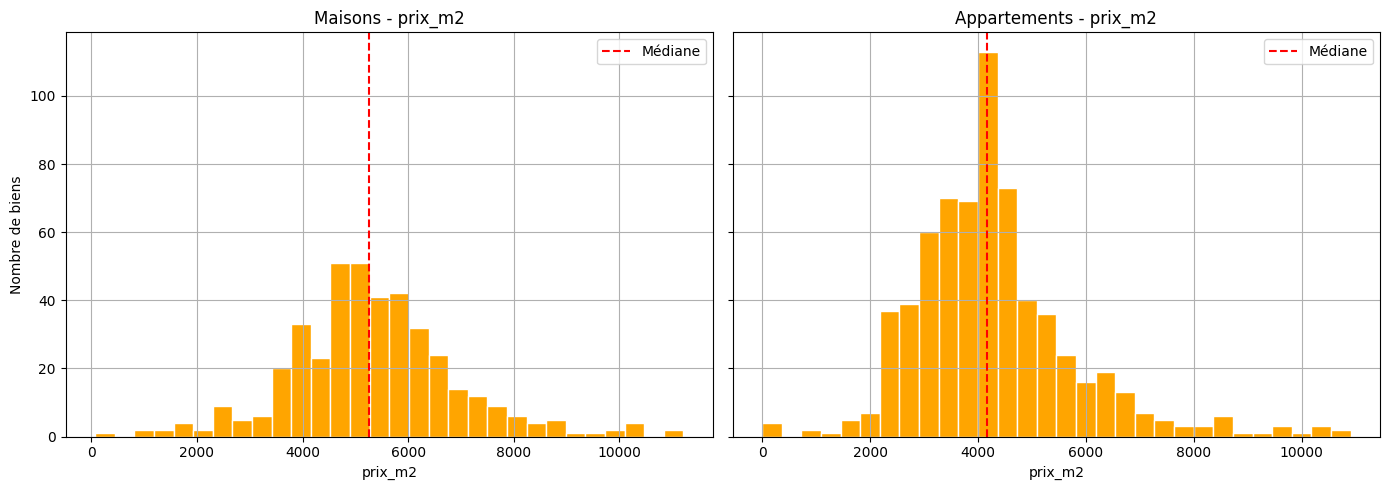

In [9]:
# Créer la figure et les 2 sous-graphiques côte à côte
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# --- 1. Histogramme pour les maisons ---
axs[0].hist(df_bx_maisons_clean['prix_m2'], bins=30, color='orange', edgecolor='w')
axs[0].axvline(np.median(df_bx_maisons_clean['prix_m2']), color='red', linestyle='--', label='Médiane')
axs[0].set_title("Maisons - prix_m2")
axs[0].set_xlabel("prix_m2")
axs[0].set_ylabel("Nombre de biens")
axs[0].grid(True)
axs[0].legend()

# --- 2. Histogramme pour les appartements ---
axs[1].hist(df_bx_apt_clean['prix_m2'], bins=30, color='orange', edgecolor='w')
axs[1].axvline(np.median(df_bx_apt_clean['prix_m2']), color='red', linestyle='--', label='Médiane')
axs[1].set_title("Appartements - prix_m2")
axs[1].set_xlabel("prix_m2")
axs[1].grid(True)
axs[1].legend()

# Ajuster l'espacement
plt.tight_layout()
plt.show()

In [10]:
# Pour les maisons
df_bx_maisons = df_bx_maisons_clean[(df_bx_maisons_clean["prix_m2"] >= 1500) & (df_bx_maisons_clean["prix_m2"] <= 5000)]

# Pour les appartements
df_bx_apt = df_bx_apt_clean[(df_bx_apt_clean["prix_m2"] >= 2000) & (df_bx_apt_clean["prix_m2"] <= 7000)]

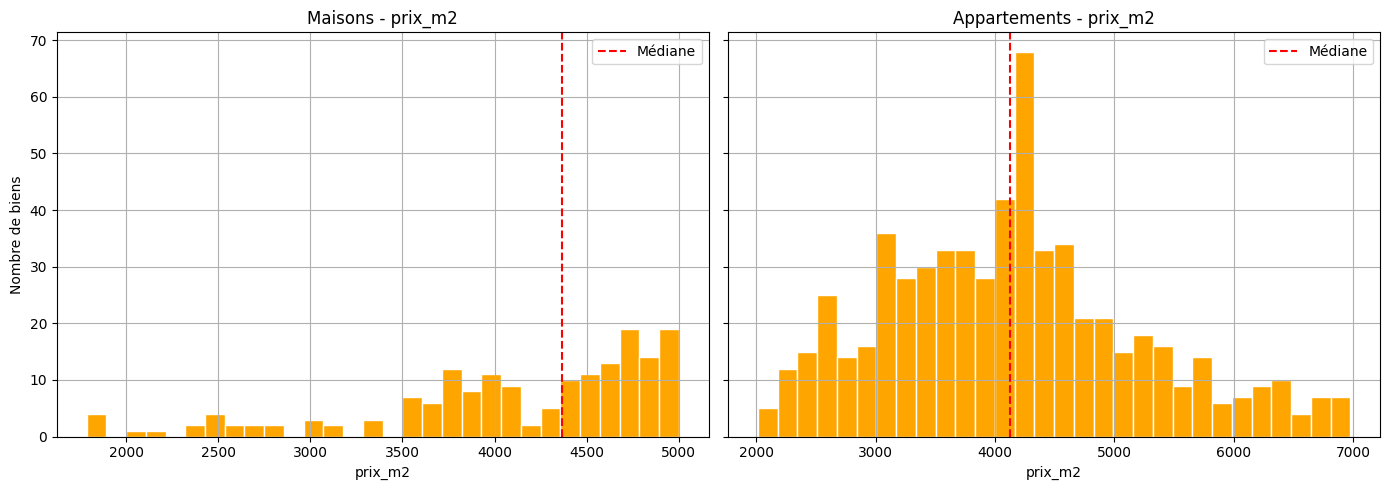

In [11]:
# Créer la figure et les 2 sous-graphiques côte à côte
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# --- 1. Histogramme pour les maisons ---
axs[0].hist(df_bx_maisons['prix_m2'], bins=30, color='orange', edgecolor='w')
axs[0].axvline(np.median(df_bx_maisons['prix_m2']), color='red', linestyle='--', label='Médiane')
axs[0].set_title("Maisons - prix_m2")
axs[0].set_xlabel("prix_m2")
axs[0].set_ylabel("Nombre de biens")
axs[0].grid(True)
axs[0].legend()

# --- 2. Histogramme pour les appartements ---
axs[1].hist(df_bx_apt['prix_m2'], bins=30, color='orange', edgecolor='w')
axs[1].axvline(np.median(df_bx_apt['prix_m2']), color='red', linestyle='--', label='Médiane')
axs[1].set_title("Appartements - prix_m2")
axs[1].set_xlabel("prix_m2")
axs[1].grid(True)
axs[1].legend()

# Ajuster l'espacement
plt.tight_layout()
plt.show()

In [12]:
# Charger la pipeline sauvegardée (ex : pour les appartements)
pipeline_appartement = joblib.load("../models/pipeline_appartement_models.pkl")

# Pour les maisons (si tu l'as aussi sauvegardée)
pipeline_maison = joblib.load("../models/pipeline_maison_models.pkl")

print(type(pipeline_appartement))

<class 'dict'>


## Préparer les données pour l'entraînement

In [13]:
# Variables explicatives
features_maison = ["Surface terrain", "Surface reelle bati"]
features_appartement = ["Nombre de lots", "Surface reelle bati"]

#maison
X_bx_maisons = df_bx_maisons[features_maison]
y_bx_maisons = df_bx_maisons["prix_m2"]

# appartement
X_bx_apt = df_bx_apt[features_appartement]
y_bx_apt = df_bx_apt["prix_m2"]

In [ ]:
# Liste pour stocker les résultats


def affiche_score(pipeline, X_bx, y_bx):
    results = []

    for name, model in pipeline.items():
        y_pred = model.predict(X_bx)
        
        mse = mean_squared_error(y_bx, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_bx, y_pred)
        r2 = r2_score(y_bx, y_pred)
        
        results.append({
            "Modele": name,
            "MSE": mse,
            "RMSE": rmse,
            "MAE": mae,
            "R2": r2
        })
    return pd.DataFrame(results)


# Optionnel : trier par MAE ou un autre critère
df_results_maison = affiche_score(pipeline_maison,X_bx_maisons, y_bx_maisons).sort_values(by="MAE")
df_results_appartement = affiche_score(pipeline_appartement, X_bx_apt, y_bx_apt).sort_values(by="MAE")

# Affichage final
print("pour les maison:")
print(df_results_maison)
print("pour les appartements:")
print(df_results_appartement)

meilleur_modele_maison = df_results_maison.iloc[0]["Modele"]
meilleur_modele_appartement = df_results_appartement.iloc[0]["Modele"]

# 💾 Sauvegarde des pipelines
os.makedirs("../app/models/Bordaux", exist_ok=True)
joblib.dump(pipeline_maison[meilleur_modele_maison], "../app/models/Bordaux/models_maison_Bordaux.pkl")
joblib.dump(pipeline_appartement[meilleur_modele_appartement], "../app/models/Bordaux/models_appartement_Bordaux.pkl")

pour les maison:
             Modele           MSE         RMSE          MAE        R2
3           XGBoost  2.135536e+06  1461.347459  1344.707042 -2.495640
4   VotingRegressor  2.157117e+06  1468.712855  1349.486451 -2.530965
0  LinearRegression  2.197001e+06  1482.228466  1351.890915 -2.596251
2      RandomForest  2.204718e+06  1484.829409  1366.579437 -2.608883
1      DecisionTree  2.352982e+06  1533.943427  1376.202154 -2.851575
pour les appartements:
             Modele           MSE         RMSE         MAE        R2
3           XGBoost  1.557951e+06  1248.179045  964.590612 -0.338324
4   VotingRegressor  1.563027e+06  1250.210801  967.887759 -0.342684
0  LinearRegression  1.569850e+06  1252.936445  969.396889 -0.348545
1      DecisionTree  1.633762e+06  1278.186832  989.325224 -0.403447
2      RandomForest  1.645792e+06  1282.884079  994.704720 -0.413781


,steps,"[('scaler', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None


In [15]:
import pandas as pd
import json

# 1. Charger les résultats JSON de Lille
with open("resultats_modeles_maison_appartement.json") as f:
    results_lille = json.load(f)

df_lille_maison = pd.DataFrame(results_lille["maison"])
df_lille_appart = pd.DataFrame(results_lille["appartement"])

# 2. Supposons que tu as déjà deux DataFrames de Bordeaux :
# df_bordeaux_maison et df_bordeaux_appart (avec mêmes colonnes : Modele, MSE, RMSE, MAE, R2)

def compare_models(df_lille, df_bordeaux, ville1="Lille", ville2="Bordeaux"):
    df_merged = pd.merge(df_lille, df_bordeaux, on="Modele", suffixes=(f"_{ville1}", f"_{ville2}"))
    
    metrics = ["RMSE", "MAE", "R2"]
    for metric in metrics:
        diff_col = f"{metric}_diff"
        df_merged[diff_col] = (
            abs(df_merged[f"{metric}_{ville1}"] - df_merged[f"{metric}_{ville2}"]) 
            / abs(df_merged[f"{metric}_{ville2}"])
        ) * 100

    # Score global : moyenne des différences en %
    df_merged["ecart_moyen_%"] = df_merged[[f"{m}_diff" for m in metrics]].mean(axis=1)

    # Classement par stabilité
    df_sorted = df_merged.sort_values("ecart_moyen_%")
    
    return df_sorted[["Modele"] + [f"{m}_diff" for m in metrics] + ["ecart_moyen_%"]]

# affichage
df_result_maison = compare_models(df_lille_maison, df_results_maison)
df_result_appartement = compare_models(df_lille_appart, df_results_appartement)

print("comparatif écart Lille Bordaux (maison)")
display(df_result_maison)
print("comparatif écart Lille Bordaux (appartement)")
display(df_result_appartement)

# meilleur_modele_maison = df_result_maison.iloc[0]["Modele"]
# meilleur_modele_appartement = df_result_appartement.iloc[0]["Modele"]

# # 💾 Sauvegarde des pipelines
# joblib.dump(pipeline_maison[meilleur_modele_maison], "../api/models/maison_models.pkl")
# joblib.dump(pipeline_appartement[meilleur_modele_appartement], "../api/models/appartement_models.pkl")

comparatif écart Lille Bordaux (maison)


,Modele,RMSE_diff,MAE_diff,R2_diff,ecart_moyen_%
2,RandomForest,24.407104,42.828503,97.079564,54.771724
1,DecisionTree,27.403393,41.783546,97.919889,55.702276
3,XGBoost,25.557160,43.389698,99.561483,56.169447
0,LinearRegression,26.308497,42.966473,99.262290,56.179087
4,VotingRegressor,25.933321,43.416656,99.570667,56.306882


comparatif écart Lille Bordaux (appartement)


,Modele,RMSE_diff,MAE_diff,R2_diff,ecart_moyen_%
0,LinearRegression,12.904178,2.744544,77.216873,30.955198
1,DecisionTree,5.452726,1.480344,104.964930,37.299333
2,RandomForest,3.974210,2.954747,109.740144,38.889700
4,VotingRegressor,6.069334,1.982131,115.017618,41.023028
3,XGBoost,3.803337,4.560085,127.934271,45.432564
